# **Implementation of a Music Recommendation System for Spotify Application Users**

A recommendation system is a system that can suggest information to users that comes from user observations. One of the goals of this project is to implement a recommendation system method in the field of music, so that users can receive several song recommendations interpersonally according to the user's interests. The dataset used in this project comes from the [Spotify Playlists](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists?select=spotify_dataset.csv) dataset.

### **Business Statement**
Song is one of the entertainment media that never escapes the times. For the connoisseurs, the song is something that is very important because the song is an entertainment that will be listened to according to their mood. Because there are so many songs available, it makes it difficult for many people to choose the song they want to hear. So that with the Recommendation System, it is hoped that it can provide information that is relevant to what the user wants.

**Problem Statement**

Based on this statement, the issues raised in this project are explained as follows:
- Who is the user_id who listens to music the most?
- Who is the artist whose songs are played the most?
- What is the title of the song that the user likes the most?
- What is the name of the playlist most often played by the majority of users?
- Based on the insights obtained from the data, what is the right way to develop a recommendation system model for users?


**Goals**

To answer these questions, create a recommendation system with the following goals:

- Get insight of data.
- Develop model with minimizing error values in order to form the best recommendation system in predicting artists that are relevant to user interests.

**Solution Statement**

So to achieve the desired goals, a recommendation system will be formed with the following flow.

1. Data Understanding
> Data Understanding is the initial stage of the project to understand data. In this case, we have 4 variables which is user_id, artistname, trackname and playlistname.

2. Univariate Exploratory Data Analysis
> At this stage, analyze and explore several variables in the data. So knowing the relationship between one variable with other variables.

3. Data Preparation
> This is the data preparation stage before the data is used for further processing. At this stage, several variables will be combined so that they become one unified file that is intact and ready to be used in the modeling stage, like user_id, artist_id, song playback frequency and artist or singer name.

4. Model Delopment with Hybrid Filtering
> At this stage the system recommends several singers for the user, where the recommendation is obtained from the closeness between the recommended singers and the frequency history of the user listening to songs from several singers. From the number of times the singer's song is played, other singers will be identified with almost the same song genre as the singer to be recommended to the user. **The algorithm used is LightFM, a combined method of collaborative filtering and content-based filtering**. *LightFM produces more relevant recommendations compared to collaborative filtering or content-based filtering in general.*

What are you waiting for? Let's get to know more about this project. Hope you enjoy with this journey !

## **Data Understanding**

This code from [Spotify Recommendation - LightFM](https://www.kaggle.com/code/emredarende/spotify-recommendation-lightfm) and [LightFM](https://www.kaggle.com/code/shreyashnadage/lightfm/notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
!{sys.executable} -m pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 14.0 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=738328 sha256=d856fc1b353cf10d5cbe6d73243e4da8b2129e60ba853e514c3904d8adcebc99
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm


In [ ]:
#import library
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import sparse
import random
import lightfm 
from lightfm import LightFM, cross_validation
import random
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics.pairwise import cosine_similarity
import ast
from scipy.spatial.distance import cosine, euclidean, hamming
from sklearn.preprocessing import normalize
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

The data in this project comes from [Spotify Playlist](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists). Spotify_dataset have 4 variables which is user id, artist name, track name and playlist name.

Description of these variables are as follows.

|Variable | Description|
|---|---|
|user_id| id of spotify app user
|artistname| The name of the artist or singer that the user listens to
|trackname| The name of the song played by the user
|playlistname| The name of the playlist of the song the user is currently listening to

>**Note:** Because the amount of data is quite large, the data for this project is 50% of the actual number of datasets so the process of running the model can be faster.

In [ ]:
#import data
random.seed(123)
spotify_playlist = pd.read_csv('/content/drive/MyDrive/spotify/spotify_dataset.csv', 
                              error_bad_lines=False, warn_bad_lines=False, 
                               skiprows=lambda i:i>0 and random.random()>0.50) #get 50% random data of spotify dataset
spotify_playlist.head(5)

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,All Be Okay,HARD ROCK 2010


In [ ]:
spotify_playlist.shape

(6447654, 4)

There are 6,447,654 data used, where the column name labeling still needs to be improved to make it more accessible.

In [ ]:
#fix columns name
spotify_playlist.columns = spotify_playlist.columns.str.replace('"','').str.replace('name','').str.replace(' ','')
spotify_playlist.head(5)

,user_id,artist,track,playlist
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,All Be Okay,HARD ROCK 2010


Column name has been improved. The following is a description of the dataset.

In [ ]:
spotify_playlist.describe()

,user_id,artist,track,playlist
count,6447654,6430785,6447612,6447040
unique,15716,220001,1376213,153048
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,147506,18141,3336,668203


**Of the 220,001 existing artists, Daft Punk is a singer whose songs are frequently played by users**. \
There is indications that there are missing value data or 'Not Specified' data in the artist, track and playlist columns.

In [ ]:
spotify_playlist[spotify_playlist['artist']=='Daft Punk'].describe()

,user_id,artist,track,playlist
count,18141,18141,18141,18141
unique,3537,1,473,3723
top,ce7eab9cbb66a49a8b71c751458e8663,Daft Punk,Get Lucky - Radio Edit,Starred
freq,130,18141,1174,2279


## **Data Preprocessing**

At this stage, it aims to overcome the missing values in the spotify_playlist dataset.

In [ ]:
spotify_playlist.isna().sum()

user_id         0
artist      16869
track          42
playlist      614
dtype: int64

This is a playlist column dataset that has a missing value.

In [ ]:
spotify_playlist[spotify_playlist['playlist'].isna()]

,user_id,artist,track,playlist
4265,c50566d83fba17b20697039d5824db78,SNAP!,"Rhythm Is A Dancer - Original 12"",Everything a...",NaN
9550,1ed9910b0db7fcb779ec65b2ded4892f,Sandy B,"Make the World Go Round - Deep Dish Vocal 12"",...",NaN
9830,1ed9910b0db7fcb779ec65b2ded4892f,Kid Creole And The Coconuts,"I'm A Wonderful Thing, Baby - Original 12"",Sta...",NaN
38185,6cdb890a9fff57be31b072777350e632,Titus Andronicus,"Theme From “Cheers"",I Love Myself (2015)""",NaN
74845,059afab6c1de00c67152ba78ac8db80f,David Bowie,"Dead Man Walking - Moby Mix 2 US Promo 12"",Dav...",NaN
...,...,...,...,...
6369222,962c01177a1cda4c0e2868936ab88acc,INXS,"New Sensation - Nick 7"",Starred""",NaN
6413660,2b58df4983e40e036623f3f6543943ca,SNAP!,"Rhythm Is A Dancer - Original 12"",Starred""",NaN
6422752,85d9ab164a072bfad1480d328e627e41,Amaia Montero,"4 "",Amaia Montero – Amaia Montero""",NaN
6436050,6710bd50ccdbb3c5308adea240695e6a,SNAP!,"Rhythm Is A Dancer - Original 12"",Sugerencias ...",NaN


It is known that the most missing values are in the artist column; henceforth let's look at the form of the dataset when the artist column has missing values.

In [ ]:
spotify_playlist[spotify_playlist['artist'].isna()]

,user_id,artist,track,playlist
401,07f0fc3be95dcd878966b1f9572ff670,NaN,07 - echoes,Starred
1332,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Im Not Okay (I Promise) ~ My Chemical Romance,ngt emo eller
1333,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Just The Girl - The Click Five Cover,ngt emo eller
1334,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Low - Sleeping With Sirens Cover,ngt emo eller
1335,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Pierce The Veil - Disasterology ( Lyrics ),ngt emo eller
...,...,...,...,...
6445313,bf7fd0e14a76a1945d1bd0cce485fd26,NaN,Ponta de Areia,Jazz
6445331,bf7fd0e14a76a1945d1bd0cce485fd26,NaN,Riddle Me This,Jazz
6445351,bf7fd0e14a76a1945d1bd0cce485fd26,NaN,She Got to You,Jazz
6445445,bf7fd0e14a76a1945d1bd0cce485fd26,NaN,Travelers,Jazz


The dataframe shows that the artist column, which has 16869 missing data values, can be labeled as **Not Specified** data.

In [ ]:
spotify_playlist[spotify_playlist['track'].isna()]

,user_id,artist,track,playlist
112000,42f5289bfa83726edd652392ea09984a,NaN,NaN,Starred
134232,48388a944d86ca079dac6e5d825a2b57,Silversun Pickups,NaN,No One Sleeps When I’m Awake
138459,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,NaN,Lounge
229558,db0d3d755f35fa0ed3985a0be1df0e49,Tamia,NaN,2
229749,db0d3d755f35fa0ed3985a0be1df0e49,Krezip,NaN,moi
284861,c0cf65e23e3df6f75d60f26af75c7162,NaN,NaN,Groovin'
423428,798ddeb5ce830765d64b1ff2de51660d,蘇永康,NaN,7- Shanghai
591295,a21cb7091c1bd79f7b21414b1d07ebdf,NaN,NaN,Fuckin' electro-pop-rockin' stuff
602874,ce7eab9cbb66a49a8b71c751458e8663,NaN,NaN,Fk'N Electro
605018,ce7eab9cbb66a49a8b71c751458e8663,NaN,NaN,Starred


And then, in the track column there are 624 data missing values. Where in the second order data with an artist named **Silversun Pickups**, and user_id: **48388a944d86ca079dac6e5d825a2b57**, the title of the song is unknown. So let's see if there is another user_id in the 'No one Sleeps When I'm Awake' playlist that plays songs from artist 'Silversun Pickups'.

In [ ]:
spotify_playlist.loc[(spotify_playlist['artist']=='Silversun Pickups') & (spotify_playlist['playlist']=='No One Sleeps When I’m Awake')] 

,user_id,artist,track,playlist
134232,48388a944d86ca079dac6e5d825a2b57,Silversun Pickups,NaN,No One Sleeps When I’m Awake
134280,48388a944d86ca079dac6e5d825a2b57,Silversun Pickups,Well Thought Out Twinkles,No One Sleeps When I’m Awake


In the 'No One Sleeps When I'm Awake' playlist for artist Silversun Pickups, **it shows that there is a possibility that the song title in the NaN data is 'Well Thought Out Twinkles**. This is also supported because the user_id that hears the song is the same user_id.

----

And then, let's take a look at the other NaN data in the track column. For example, for the artist 'Touvic Farroukh' with the playlist title 'Lounge'.

In [ ]:
spotify_playlist.loc[(spotify_playlist['artist']=='Toufic Farroukh') & (spotify_playlist['playlist']=='Lounge')] 

,user_id,artist,track,playlist
138459,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,NaN,Lounge
138471,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Destins Et Desirs,Lounge
138476,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,For Once,Lounge
138480,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Hanina,Lounge
138494,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Like Desire - Moonfish Remix,Lounge
138502,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Only Lonely,Lounge
138511,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Radio City,Lounge
138517,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Scarecrow And Peacock,Lounge
138546,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Ya Habibi,Lounge
138547,317a0f3ff15ff0cd8b12fe06f390a24f,Toufic Farroukh,Ya Nassim Alrouh,Lounge


For the artist 'Touvic Farroukh' in the 'Lounge' playlist, **it shows that there are many possibilities to fill in the missing values** in the track column NaN data.

---

Seeing conditions like those of the two artists, it can be concluded that the missing value cannot be identified. **So to overcome the missing value, the data will be substituted with the 'Not Specified' label value.**

In [ ]:
spotify_playlist[(spotify_playlist['artist'].isna()) & (spotify_playlist['track'].isna())].isna().sum()

user_id      0
artist      26
track       26
playlist     0
dtype: int64

In [ ]:
spotify_playlist.loc[(spotify_playlist['artist'].isna()) & (spotify_playlist['track'].isna())]

,user_id,artist,track,playlist
112000,42f5289bfa83726edd652392ea09984a,NaN,NaN,Starred
284861,c0cf65e23e3df6f75d60f26af75c7162,NaN,NaN,Groovin'
591295,a21cb7091c1bd79f7b21414b1d07ebdf,NaN,NaN,Fuckin' electro-pop-rockin' stuff
602874,ce7eab9cbb66a49a8b71c751458e8663,NaN,NaN,Fk'N Electro
605018,ce7eab9cbb66a49a8b71c751458e8663,NaN,NaN,Starred
994429,d7315cde05dc30d70853fc782d19183a,NaN,NaN,2012 - New Music
1069274,9ecbbafe05e7c74298282930cc8ca102,NaN,NaN,Manza
1546888,11da254d9d1948488318e3ea286bf484,NaN,NaN,Top ~100 2013
1547587,11da254d9d1948488318e3ea286bf484,NaN,NaN,drygmaskens Top 20 Albums 2013
1778844,70e4277376547ba0c5a5594968dd9df5,NaN,NaN,iphone car


Then if we want to see, **is there any NaN data on artist; tracks; and playlist for the same user_id**, can be shown as follows.

In [ ]:
spotify_playlist.loc[(spotify_playlist['artist'].isna()) & (spotify_playlist['track'].isna()) & (spotify_playlist['playlist'].isna())] 

,user_id,artist,track,playlist


In [ ]:
spotify_playlist.loc[(spotify_playlist['artist'].isna()) & (spotify_playlist['playlist'].isna())]

,user_id,artist,track,playlist


In [ ]:
spotify_playlist.loc[(spotify_playlist['track'].isna()) & (spotify_playlist['playlist'].isna())]

,user_id,artist,track,playlist


**Some of the code above shows that there is no NaN data for the same user_id.**And then, this is a process to fix missing values. 

In [ ]:
spotify_playlist.fillna('Not Specified', inplace=True)
spotify_playlist.isna().sum()

user_id     0
artist      0
track       0
playlist    0
dtype: int64

## **Univariate Exploratory Data Analysis**

The following is a univariate data exploration.

#### **Top User**
users who listen to songs the most

In [ ]:
sort_playlist = spotify_playlist.groupby("user_id")['track'].count().sort_values(ascending=False)
sort_playlist.head()

user_id
4398de6902abde3351347b048fcdc287    147506
7ee2b92c5bcf6133b8132363e5bda960     45474
99deafd9b792af8e6a535483088faef2     32982
fa849dabeb14a2800ad5130907fc5018     30337
6b85a8076b4f3b1036ef15f09e2feeeb     19874
Name: track, dtype: int64

In [ ]:
sort_playlist.describe()

count     15716.000000
mean        410.260499
std        1489.222371
min           1.000000
25%          49.000000
50%         184.000000
75%         444.000000
max      147506.000000
Name: track, dtype: float64

The most song played by user was hit **147,506** play, which is by user id '4398de6902abde3351347b048fcdc287'. This is more than three times than the second rank user

(array([1.5709e+04, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 1.475150e+04, 2.950200e+04, 4.425250e+04,
        5.900300e+04, 7.375350e+04, 8.850400e+04, 1.032545e+05,
        1.180050e+05, 1.327555e+05, 1.475060e+05]),
 <a list of 10 Patch objects>)

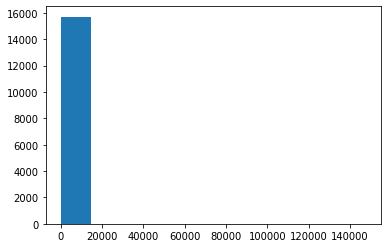

In [ ]:
plt.hist(sort_playlist)

most user play songs less than 20.000 times. this grafik is not balance between the frequency of the song being played, so we are going to use 25% of data to see the distribution

(array([887., 635., 459., 324., 367., 269., 232., 260., 239., 248.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <a list of 10 Patch objects>)

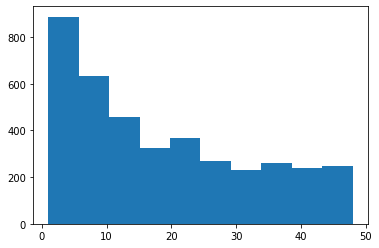

In [ ]:
#histogram of user whom play song less than 25% of others
plt.hist(sort_playlist[sort_playlist<49])

we still have more data on the right, so that means a lot of users only play songs few times

#### **The most played artist by top user**

In [ ]:
artist_top_user = spotify_playlist[spotify_playlist['user_id']==sort_playlist.index[0]].groupby(['artist'])['user_id'].count().sort_values(ascending=False)
artist_top_user = artist_top_user.reset_index()
print('the most played artist by top user is', artist_top_user['artist'][0], 'and played', artist_top_user['user_id'][0], 'times')

the most played artist by top user is Boyce Avenue and played 71 times


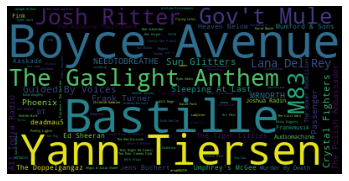

other artist that have been played by top user are Bastille , Yann Tiersen , and The Gaslight Anthem


In [ ]:
artist_top_user = spotify_playlist[spotify_playlist['user_id']==sort_playlist.index[0]].groupby(['artist'])['user_id'].count().sort_values(ascending=False)
wc = WordCloud().generate_from_frequencies(artist_top_user)

plt.imshow(wc)
plt.axis('off')
plt.show()

print('other artist that have been played by top user are', artist_top_user.index[1], ',', artist_top_user.index[2], ', and', artist_top_user.index[3])

#### **The most played song by top user**

In [ ]:
track_top_user = spotify_playlist[spotify_playlist['user_id']==sort_playlist.index[0]].groupby(['track'])['user_id'].count().sort_values(ascending=False)
track_top_user = track_top_user.reset_index()
print('the most played song by top user is', track_top_user['track'][0], 'and played', track_top_user['user_id'][0], 'times')

the most played song by top user is Without You and played 19 times


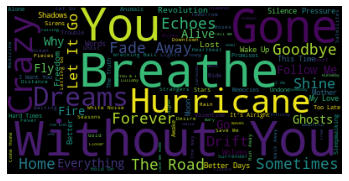

other songs that have been played by top user are Breathe , You , and Gone


In [ ]:
track_top_user = spotify_playlist[spotify_playlist['user_id']==sort_playlist.index[0]].groupby(['track'])['user_id'].count().sort_values(ascending=False)
wc = WordCloud().generate_from_frequencies(track_top_user)

plt.imshow(wc)
plt.axis('off')
plt.show()

print('other songs that have been played by top user are', track_top_user.index[1], ',', track_top_user.index[2], ', and', track_top_user.index[3])

#### **Top Playlist**
These are top playlist by all user

In [ ]:
top_playlist = spotify_playlist.groupby('playlist')['user_id'].count().sort_values(ascending=False)
top_playlist = top_playlist.reset_index()
print('the most played playlist by user is', top_playlist['playlist'][0], 'and played', top_playlist['user_id'][0], 'times')

the most played playlist by user is Starred and played 668203 times


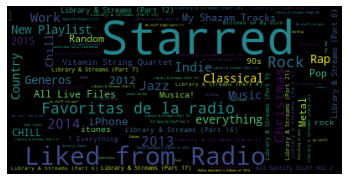

other playlist that have been played by user are Liked from Radio , Favoritas de la radio , and Rock


In [ ]:
top_playlist = spotify_playlist.groupby('playlist')['user_id'].count().sort_values(ascending=False)
wc = WordCloud().generate_from_frequencies(top_playlist)

plt.imshow(wc)
plt.axis('off')
plt.show()

print('other playlist that have been played by user are', top_playlist.index[1], ',', top_playlist.index[2], ', and', top_playlist.index[3])

In [ ]:
spotify_playlist[spotify_playlist['playlist']=='Starred'].describe()

,user_id,artist,track,playlist
count,668203,668203,668203,668203
unique,4694,55929,277819,1
top,4398de6902abde3351347b048fcdc287,Radiohead,Radioactive,Starred
freq,23688,2845,261,668203


#### **Top Tracks**
These are the most played songs by user

In [ ]:
top_track = spotify_playlist.groupby('track')['user_id'].count().sort_values(ascending=False)
top_track = top_track.reset_index()
print('the most played songs by user is', top_track['track'][0], 'and played', top_track['user_id'][0], 'times')

the most played songs by user is Intro and played 3336 times


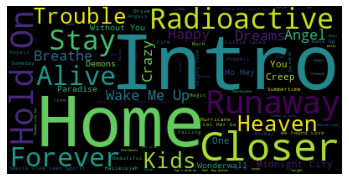

other songs that have been played by user are Home , Closer , and Runaway


In [ ]:
top_track = spotify_playlist.groupby('track')['user_id'].count().sort_values(ascending=False)
wc = WordCloud().generate_from_frequencies(top_track)

plt.imshow(wc)
plt.axis('off')
plt.show()

print('other songs that have been played by user are', top_track.index[1], ',', top_track.index[2], ', and', top_track.index[3])

In [ ]:
spotify_playlist[spotify_playlist['track']=='Intro'].describe()

,user_id,artist,track,playlist
count,3336,3336,3336,3336
unique,2375,1001,1,2500
top,99deafd9b792af8e6a535483088faef2,The xx,Intro,Starred
freq,11,677,3336,244


#### **Top Artist**
These are the most played artist by user

In [ ]:
top_artist = spotify_playlist.groupby('artist')['user_id'].count().sort_values(ascending=False)
top_artist = top_artist.reset_index()
print('the most played artists by user is', top_artist['artist'][0], 'and played', top_artist['user_id'][0], 'times')

the most played artists by user is Daft Punk and played 18141 times


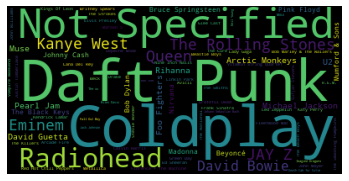

other artist that have been played by user are Coldplay , Not Specified , and Radiohead


In [ ]:
top_artist = spotify_playlist.groupby('artist')['user_id'].count().sort_values(ascending=False)
wc = WordCloud().generate_from_frequencies(top_artist)

plt.imshow(wc)
plt.axis('off')
plt.show()

print('other artist that have been played by user are', top_artist.index[1], ',', top_artist.index[2], ', and', top_artist.index[3])

In [ ]:
spotify_playlist[spotify_playlist['artist']=='Daft Punk'].describe()

,user_id,artist,track,playlist
count,18141,18141,18141,18141
unique,3537,1,473,3723
top,ce7eab9cbb66a49a8b71c751458e8663,Daft Punk,Get Lucky - Radio Edit,Starred
freq,130,18141,1174,2279


In [ ]:
spotify_playlist[spotify_playlist['track']=='Get Lucky - Radio Edit'].describe()

,user_id,artist,track,playlist
count,1175,1175,1175,1175
unique,1021,2,1,865
top,46724138a326c3a35dbd9ebb6f615e5e,Daft Punk,Get Lucky - Radio Edit,Starred
freq,4,1174,1175,211


In [ ]:
spotify_playlist[spotify_playlist['artist']=='Coldplay'].describe()

,user_id,artist,track,playlist
count,17782,17782,17782,17782
unique,3582,1,374,4224
top,1bb0e0c5d0321a0469ab1a6e1f3d853b,Coldplay,Fix You,Starred
freq,126,17782,758,2418


**There were 3582 users who played songs from Singer Ed Sheeran**, where the song that was played the most was called Fix You.

## **Data Preparation**

At this stage, there are 5 steps before the data is ready for training. Consists of the process of filtering data to merge data into one unit.
- In the first step, the data will be filtered based on artists whose songs have been listened to more than 50 times from the total data.
- Then step 2, the data will be filtered based on the user id which is in the unique data category regardless of the NaN value and has listened to more than 10 songs.
- The 3rd step, calculates the frequency of the number of songs that the user_id listens to for each artist. The calculation of the number of frequencies is stored in a new table, namely spotify_freq,
- Step 4, get a list of artists including unique data from spotify_freq data. Where the list is stored in the spotify_artist table, so that the dataset is the name of the artist (singer) and the id of the artist.
- The 5th step, which is to merge the data in the spotify_freq data with spotify_artist. The data is stored in the spotify_freq dataset.

In [ ]:
#first step
spotify_playlist = spotify_playlist.groupby('artist').filter(lambda x: len(x)>=50) #filtering the database used based on groups of artists who have a track record of more than 50 songs
print(spotify_playlist.shape)
print('After filtering based on number of songs, there are ', '{0:,}'.format(spotify_playlist.shape[0]), ' data were obtained from ', spotify_playlist.shape[1], ' variables.')

(5355565, 4)
After filtering based on number of songs, there are  5,355,565  data were obtained from  4  variables.


In [ ]:
#second step
spotify_playlist = spotify_playlist[spotify_playlist.groupby('user_id').artist.transform('nunique')>=10]#filtering the database based on users who have played songs more than 10 artists
print(spotify_playlist.shape)
print('After filtering based on the song played by the user, there are ', '{0:,}'.format(spotify_playlist.shape[0]), 'data were obtained from ', spotify_playlist.shape[1], 'variables.')

(5308123, 4)
After filtering based on the song played by the user, there are  5,308,123 data were obtained from  4 variables.


In [ ]:
spotify_playlist.describe()

,user_id,artist,track,playlist
count,5308123,5308123,5308123,5308123
unique,12924,14277,846342,133304
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,64765,17931,2855,571762


In [ ]:
#third step
size = lambda x: len(x)
spotify_freq = spotify_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
spotify_freq.head(10)

,user_id,artist,freq
1256999,c8e0b3f55f4ecd3c0c7947a18e7472d8,Not Specified,1706
1393393,defced0ece4ce946160b0d2698142eac,Vitamin String Quartet,1649
246691,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,1591
412368,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,1263
1358845,d993ff8f2de226e2c6803e47a22e9d7e,Lata Mangeshkar,1171
10908,014e695cc6df96011b90a5beb3206012,Ilaiyaraaja,1133
1563273,fa849dabeb14a2800ad5130907fc5018,Peggy Lee,1076
1113098,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,1029
101367,106036f1fc9e3be1f674fb591765fb85,Grateful Dead,984
830517,82988b8fb41b233433d94b86b88b44bd,Billie Holiday,970


In [ ]:
print('Calculating the number of song frequencies that the user listens to for each artist makes it easier for us to understand\nhow interested the user is in the works of that artist or singer.\n' + '\033[1m' + 'As in the user id: '+ '\033[1m' , spotify_freq['user_id'][0], 'choose to listen to songs from singer ', spotify_freq['artist'][0], spotify_freq['freq'][0],'times.')

Calculating the number of song frequencies that the user listens to for each artist makes it easier for us to understand
how interested the user is in the works of that artist or singer.
As in the user id:  00055176fea33f6e027cd3302289378b choose to listen to songs from singer  5 Seconds Of Summer 5 times.


In [ ]:
spotify_freq['freq'].min()

1

In [ ]:
spotify_freq[spotify_freq['freq']==1]

,user_id,artist,freq
1051535,a5f8cdf3fad077b5a2ea527f55ee9aea,Lost Frequencies,1
1205160,c0d8415d70486ab46457275effb60850,The War On Drugs,1
1205876,c0efe4e704a37894150489b25eac9042,Gravediggaz,1
1037743,a35f3fe007ffb9806a93e93c1d57e936,Imagine Dragons,1
1194399,bf189a7bcfaff73e330882a11eff5782,The Who,1
...,...,...,...
144271,16b7bd1c25372424e7a963b04b6a8fb6,Senses Fail,1
769449,78a8f856d7567fa98265f4cf82d065bb,Cajun Dance Party,1
769451,78a8f856d7567fa98265f4cf82d065bb,Capital Cities,1
769453,78a8f856d7567fa98265f4cf82d065bb,Carlos Jean,1


In [ ]:
#fourth step
spotify_artist = pd.DataFrame(spotify_freq['artist'].unique())
spotify_artist = spotify_artist.reset_index()
spotify_artist = spotify_artist.rename(columns={'index':'artist_id', 0:'artist'})
spotify_artist.head(10)

,artist_id,artist
0,0,Not Specified
1,1,Vitamin String Quartet
2,2,Lata Mangeshkar
3,3,Ilaiyaraaja
4,4,Peggy Lee
5,5,Wolfgang Amadeus Mozart
6,6,Grateful Dead
7,7,Billie Holiday
8,8,Frank Sinatra
9,9,Ella Fitzgerald


Artist dataset with added index for each artist is ready.

In [ ]:
#fifth step
spotify_freq = pd.merge(spotify_freq, spotify_artist, how='inner', on='artist')
spotify_freq.head(5)

,user_id,artist,freq,artist_id
0,c8e0b3f55f4ecd3c0c7947a18e7472d8,Not Specified,1706,0
1,7ffae624f8f096dd429b1f7e78efb32b,Not Specified,962,0
2,67bb38768667210fe57b985c96f5fa4c,Not Specified,875,0
3,2801dbeaa27d88758fc964e70b64f7bc,Not Specified,425,0
4,c943688082716a65120321b4a0b15979,Not Specified,404,0


yay, the data is ready for the artist recommendation system modeling process based on the frequency with which the user listens to the artist's songs.

## **Model Development**

### **Create functions for recommendation system**

In [ ]:
def create_interaction_matrix(spotify,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - spotify = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = spotify.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [ ]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [ ]:
def create_item_dict(spotify,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - spotify = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(spotify.shape[0]):
        item_dict[(spotify.loc[i,id_col])] = spotify.loc[i,name_col]
    return item_dict

In [ ]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -
        Model - Trained model
    '''
    
    #uncommented for train test split
    # x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                       .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

### **Build Model**

Build a model that recommends artists or singers that users might like, based on the artist or singer whose songs the user listens to the most.

This recommendation system is formed using the Hybrid Filtering (LightFM) method.

> **LightFM represents users and items as latent factors or embeddings just like collaborative filtering. However, in cases where there is no interaction between a user and a certain item, LightFM makes predictions based on information about the user and the item as in content-based filtering**. Each user is described as a set of features that are owned by that user. Each item is also described as a set of features that the item has. As a result, the latent factor or embedding that is generated for a user is the sum of the latent factors for the user's features, as well as the items. The bias generated for a user or item is also the sum of the bias generated for each feature that the user or item has.


The following is the formation of a matrix based on user_id and artist_id for the frequency value.

In [ ]:
interactions = create_interaction_matrix(spotify = spotify_freq, user_col = "user_id", item_col = 'artist_id', rating_col = 'freq', norm= False, threshold = None)
interactions.head()

artist_id,0,1,2,3,4,5,6,7,8,9,...,14267,14268,14269,14270,14271,14272,14273,14274,14275,14276
user_id,,,,,,,,,,,,,,,,,,,,,
00055176fea33f6e027cd3302289378b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007f3dd09c91198371454c608d47f22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000b0f32b5739f052b9d40fcc5c41079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000c11a16c89aa4b14b328080f5954ee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00123e0f544dee3ab006aa7f1e5725a7,0.0,0.0,0.0,0.0,0.0,1.0,19.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(interactions.shape)
print('The matrix that is formed is ', interactions.shape[0], 'rows and ', interactions.shape[1], 'columns. The following is the distribution of training and testing data with a ratio of 80:20.')

(12924, 14277)
The matrix that is formed is  12924 rows and  14277 columns. The following is the distribution of training and testing data with a ratio of 80:20.


In [ ]:
user_dict = create_user_dict(interactions=interactions)
artist_dict = create_item_dict(spotify=spotify_artist, id_col='artist_id', name_col='artist')
x = sparse.csr_matrix(interactions.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.01, random_state=123)

#### **Running Model**


In [ ]:
%time
model = runMF(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.5 µs


In [ ]:
train_auc = auc_score(model, train, num_threads=4).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Based on the recommendation system model formed, AUC value for training data is ', train_auc, ' and AUC value for testing data is ', test_auc, '\nAs well as the difference between the AUC value of the training data and the testing data is not far enough,\nthe possibility of a bias value is also quite small.')

Based on the recommendation system model formed, AUC value for training data is  0.96757114  and AUC value for testing data is  0.9628839 
As well as the difference between the AUC value of the training data and the testing data is not far enough,
the possibility of a bias value is also quite small.


In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
print('train Precision %.2f, test Precision %.2f.' % (train_precision, test_precision))

train Precision 0.49, test Precision 0.02.


### **Example recomendation for user**

The following is an implementation of the recommendation system model that was formed for several users.

In [ ]:
rec_list = sample_recommendation_user(model = model, 
                                      interactions = interactions, 
                                      user_id = 'defced0ece4ce946160b0d2698142eac', 
                                      user_dict = user_dict,
                                      item_dict = artist_dict, 
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- Veracocha
2- Grace
3- deadmau5 + Wolfgang Gartner
4- LINKIN PARK x STEVE AOKI
5- Diplo feat. Faustix,Imanos & Kai
6- Sex Bob-Omb
7- Cappella
8- Bart Claessen
9- Rank 1
10- Chris Lake
11- Maor Levi
12- Vincent de Moor
13- Freeland
14- Letters To Cleo
15- Ian van Dahl
16- Gaia
17- Rex Mundi
18- Marcel Woods
19- Lange
20- Shwayze
21- Martin Solveig
22- Dvbbs
23- Marco V
24- The Shamen
25- Orgy
26- Big Data
27- John O'Callaghan
28- Michael Andrews
29- The Thrillseekers
30- Kim Wilde
31- Oceanlab
32- Poe
33- Super8 & Tab
34- Paul Leonard-Morgan
35- Steve Aoki
36- Schiller
37- Chelsea Wolfe
38- Mauro Picotto
39- Lisa Miskovsky
40- Solarstone
41- Eric B. & Rakim
42- Andy Moor
43- Swedish House Mafia
44- MS MR
45- Slick Rick
46- Jesus Jones
47- Blackmill
48- The Dreaming
49- Paul Oakenfold
50- London Grammar
51- Lorde
52- Sunlounger
53- Hoobastank
54- Ki:Theory
55- Conjure One
56- System F
57- Underworld
58- Mr. Pit
59- N.E.R.D.
60- Darren Korb
61- KMFDM
62- Zedd
63- Vast
64- I

**user_id = 'defced0ece4ce946160b0d2698142eac' often listens to songs by 136 artists**, starting from artist The Newcleus to the Vitamin String Quartet. So the system recommends 10 artists or singers whose songs may also be liked by users, such as **BT to Kaskade**.

In [ ]:
spotify_playlist[spotify_playlist['artist']=='BT']

,user_id,artist,track,playlist
34165,8b1fcabbb90b55f2ab66bd40d50ed02c,BT,Paralyzed [Mix Cut] - Juventa Remix,Hardwell On Air - Best Of October 2014
56690,65fdf0ad01992a87a2ddcc33f511ff00,BT,Knowledge Of Self,"Land of the Free, Home of the Brave"
89047,52305ebb9ca033cf9b887e930b497adc,BT,Skylarking [ASOT 616] - Ilan Bluestone Remix,A State Of Trance Episode 616
105964,2d05d78daedadd8f8db4b122dfdf9c32,BT,Somnambulist (Simply Being Loved),Starred
168927,a879e989ddc0b2325c6255cf77a77d44,BT,Smartbomb,Definitely not greek
...,...,...,...,...
6419379,83159f42b2627f530a5e7e619983083b,BT,Go(d)t,serene music
6419380,83159f42b2627f530a5e7e619983083b,BT,Hymn [808],serene music
6419384,83159f42b2627f530a5e7e619983083b,BT,Our Dark Garden,serene music
6419385,83159f42b2627f530a5e7e619983083b,BT,Seven-Hundred-Thirty-Nine,serene music


In [ ]:
rec_list = sample_recommendation_user(model = model, 
                                      interactions = interactions, 
                                      user_id = '031d69a7c94fdedb5e8648916af3a4e4', 
                                      user_dict = user_dict,
                                      item_dict = artist_dict, 
                                      threshold = 0,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- Nu Shooz
2- J.J. Fad
3- Mary Jane Girls
4- Klymaxx
5- Erick Sermon
6- XXXY
7- Kat Dahlia
8- Donnie McClurkin
9- Tim Berg
10- Escala
11- Jai Paul
12- Baauer
13- Wynter Gordon
14- Freestylers
15- Brownstone
16- Kingdom
17- Kierra Sheard
18- Lisa Lisa & Cult Jam
19- Cherrelle
20- Mark Morrison
21- TNGHT (Hudson Mohawke x Lunice)
22- Black Star
23- Jamie xx
24- Warren G
25- Globus
26- Mr Little Jeans
27- Kurtis Blow
28- Starkey
29- Africa HiTech
30- Solange
31- Diddy - Dirty Money
32- Julio Bashmore
33- Fake Blood
34- WZRD
35- SNAP!
36- Mosca
37- Heavy D & The Boyz
38- Alex Gaudino
39- Duck Sauce
40- Wham!
41- CeCe Winans
42- MellowHype
43- Allen Stone
44- E.S. Posthumus
45- Flux Pavilion
46- Yolanda Adams
47- Digable Planets
48- Rustie
49- James Dooley
50- Woodkid
51- Evelyn Champagne" King"
52- Star Slinger
53- Asher Roth
54- Little People
55- xxyyxx
56- Natalie Cole
57- Soul II Soul
58- Cam'Ron
59- De La Soul
60- Jacques Greene
61- Breakbot
62- Hudson Mohawke
63- Rudimen

**user_id = '031d69a7c94fdedb5e8648916af3a4e4' is a user who really enjoys listening to music**, where there is a list of 201 artists whose songs the user often listens to. Then for the recommendations given by the system, namely songs sung by **Justin Timberlake to Maria Carey**.
